## Problem Statement

This challenge aims to use time series injection information and monitoring data on a carbon capture well to predict carbon capture well injection rates deltas. Correlating the change in injection rate to the behavior of other parameters in the well can be used to provide a checkpoint against carbon migration from the well or other losses during the process.  The code developed to predict injection rate deltas based on monitoring well data can be used to validate carbon containment throughout the injection of the well. 

In [1]:
# Using AI to Validate Carbon Containment in the Illinois Basin
### First, import the necessary Python libraries, such as pandas, numpy, and scikit-learn.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import sqrt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [3]:
from boruta import BorutaPy
from __future__ import print_function
from datetime import datetime

### Loading and Preprocessing Data

Load the dataset and perform some basic preprocessing steps. This includes removing any missing values, converting categorical variables into one-hot encoded format, and scaling the data using StandardScaler.  

In [4]:
# Load the dataset
data = pd.read_csv('illinois_basing_train_04112023.csv')
data.head(3)

,SampleTimeUTC,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,...,Avg_VW1_Z04D6837Tp_F,Avg_VW1_Z03D6945Ps_psi,Avg_VW1_Z03D6945Tp_F,Avg_VW1_Z02D6982Ps_psi,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,inj_diff
0,10/1/2009 0:00,20.543221,1.880208,59.400879,89.967778,2893.787960,116.539694,2173.710958,104.061007,1599.975952,...,120.209798,3164.194175,121.361094,3184.043494,121.462733,3216.464494,120.278862,2441.864587,111.881138,NaN
1,10/1/2009 1:00,20.543221,1.374349,55.654541,89.825334,2893.793620,116.538811,2173.762679,104.049292,1599.975952,...,120.211298,3164.154578,121.360299,3184.060020,121.461173,3216.520127,120.276792,2442.006201,111.891938,0.0
2,10/1/2009 2:00,20.543221,1.315104,53.661254,89.806754,2893.791506,116.538623,2173.754085,104.050357,1599.975952,...,120.204548,3164.142426,121.352469,3184.060055,121.468179,3216.510374,120.280932,2442.070968,111.891218,0.0


In [5]:
data.columns

Index(['SampleTimeUTC', 'Avg_PLT_CO2VentRate_TPH', 'Avg_CCS1_WHCO2InjPs_psi',
       'Avg_CCS1_WHCO2InjTp_F', 'Avg_CCS1_ANPs_psi', 'Avg_CCS1_DH6325Ps_psi',
       'Avg_CCS1_DH6325Tp_F', 'Avg_VW1_WBTbgPs_psi', 'Avg_VW1_WBTbgTp_F',
       'Avg_VW1_ANPs_psi', 'Avg_VW1_Z11D4917Ps_psi', 'Avg_VW1_Z11D4917Tp_F',
       'Avg_VW1_Z10D5001Ps_psi', 'Avg_VW1_Z10D5001Tp_F',
       'Avg_VW1_Z09D5653Ps_psi', 'Avg_VW1_Z09D5653Tp_F',
       'Avg_VW1_Z08D5840Ps_psi', 'Avg_VW1_Z08D5840Tp_F',
       'Avg_VW1_Z07D6416Ps_psi', 'Avg_VW1_Z07D6416Tp_F',
       'Avg_VW1_Z06D6632Ps_psi', 'Avg_VW1_Z06D6632Tp_F',
       'Avg_VW1_Z05D6720Ps_psi', 'Avg_VW1_Z05D6720Tp_F',
       'Avg_VW1_Z04D6837Ps_psi', 'Avg_VW1_Z04D6837Tp_F',
       'Avg_VW1_Z03D6945Ps_psi', 'Avg_VW1_Z03D6945Tp_F',
       'Avg_VW1_Z02D6982Ps_psi', 'Avg_VW1_Z02D6982Tp_F',
       'Avg_VW1_Z01D7061Ps_psi', 'Avg_VW1_Z01D7061Tp_F',
       'Avg_VW1_Z0910D5482Ps_psi', 'Avg_VW1_Z0910D5482Tp_F', 'inj_diff '],
      dtype='object')

In [6]:
# Shape of data 27398 rows and 35 columns
data.shape

(27398, 35)

In [7]:
# function to count missing values
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(2)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [8]:
missing_values_table(data)

Your selected dataframe has 35 columns.
There are 30 columns that have missing values.


,Missing Values,% of Total Values
Avg_VW1_ANPs_psi,3911,14.27
Avg_VW1_Z05D6720Tp_F,3443,12.57
Avg_VW1_Z05D6720Ps_psi,3443,12.57
Avg_VW1_Z03D6945Ps_psi,3037,11.08
Avg_VW1_Z01D7061Tp_F,2290,8.36
Avg_VW1_Z01D7061Ps_psi,2091,7.63
Avg_VW1_Z06D6632Tp_F,1898,6.93
Avg_VW1_Z06D6632Ps_psi,1898,6.93
Avg_VW1_Z08D5840Tp_F,1520,5.55
Avg_VW1_Z03D6945Tp_F,1466,5.35


In [9]:
print(data.dropna().shape[0]) 
print(data.shape[0])

15637
27398


In [10]:
# % of missiing Values
print("Original Dataset Shape---->", data.shape)
print("Dataset Drop shape---->", data.dropna().shape)
print("% de missiing of Dataset---->", round(data.dropna().shape[0]*100/data.shape[0], 3)) #  57% drop 

Original Dataset Shape----> (27398, 35)
Dataset Drop shape----> (15637, 35)
% de missiing of Dataset----> 57.074


In [11]:
# Drop any rows with missing values because we have sufficient data 
data.dropna(inplace = True)

In [12]:
# Perform a statistics of all independent variables with the rest of the data.
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_PLT_CO2VentRate_TPH,15637.0,3.091337,176.229615,0.00000,0.000000,0.058333,0.144330,18333.150000
Avg_CCS1_WHCO2InjPs_psi,15637.0,1240.015799,1053.173958,0.00000,1275.434749,1336.940899,1360.880705,39032.410160
Avg_CCS1_WHCO2InjTp_F,15637.0,90.732795,61.667042,0.00000,95.277260,96.370766,96.904335,2879.416016
Avg_CCS1_ANPs_psi,15637.0,558.866981,545.239944,0.00000,517.878299,558.759567,597.380606,24105.630860
Avg_CCS1_DH6325Ps_psi,15637.0,3231.819776,201.220240,0.00000,3209.262195,3279.539551,3311.380605,3515.880615
Avg_CCS1_DH6325Tp_F,15637.0,128.195859,7.855412,0.00000,128.558852,130.188985,131.124135,135.670399
Avg_VW1_WBTbgPs_psi,15637.0,1491.958582,1142.882956,0.00000,0.000000,2282.728973,2382.147813,3296.006899
Avg_VW1_WBTbgTp_F,15637.0,66.568182,50.348492,0.00000,0.000000,103.642737,104.256701,120.056561
Avg_VW1_ANPs_psi,15637.0,515.439580,3940.016216,0.00000,0.404540,4.931946,16.114996,31993.509770
Avg_VW1_Z11D4917Ps_psi,15637.0,1299.525935,1002.292350,0.00000,0.000000,2073.118579,2073.508042,2320.289494


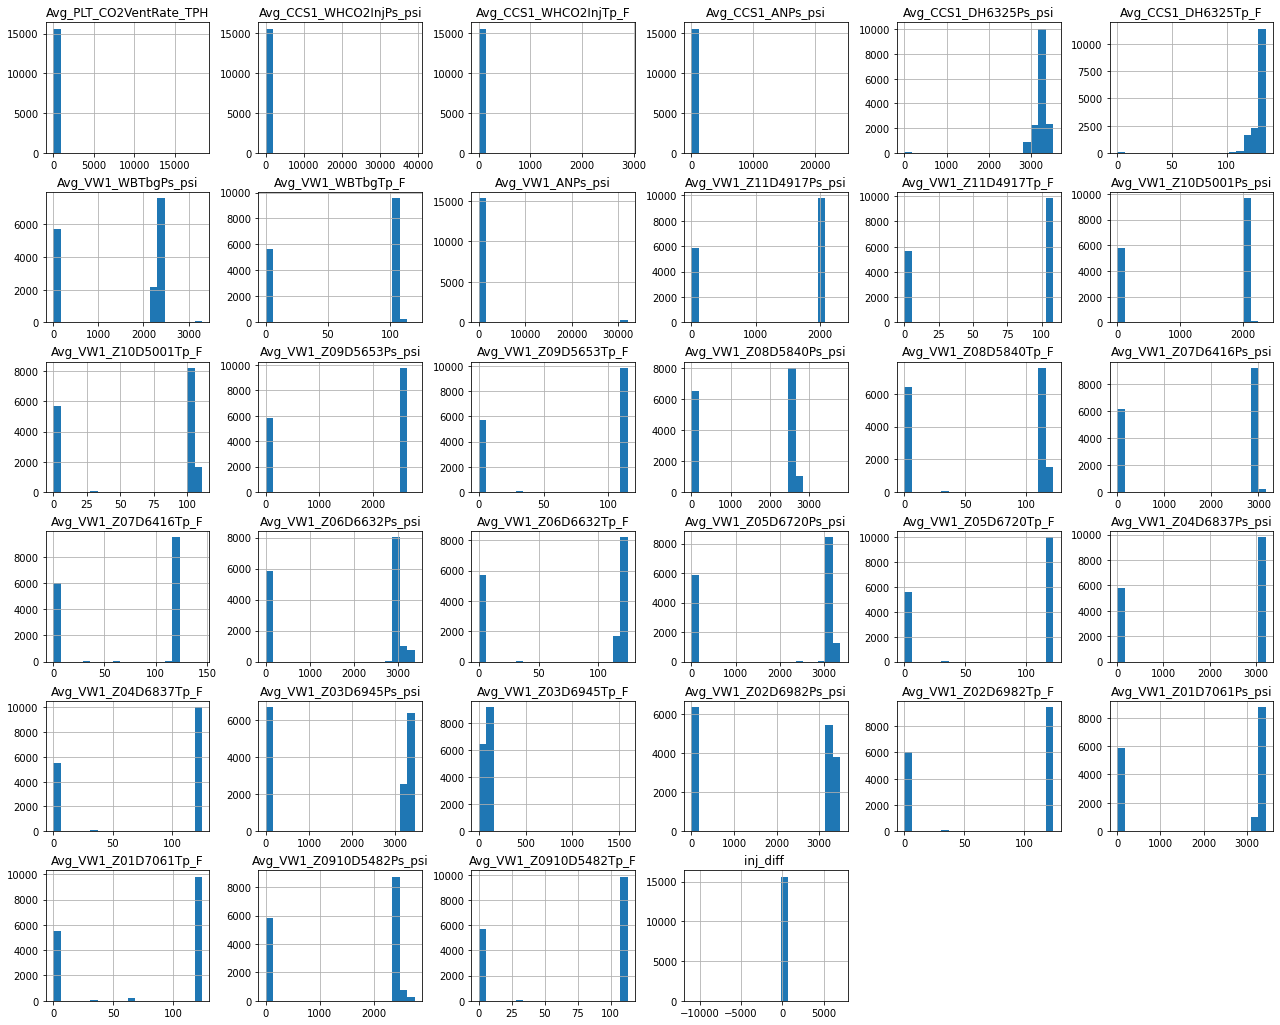

In [13]:
# Generate histograms of each feature to see their distribition
data.hist(bins=20, figsize=(22, 18))
plt.show()

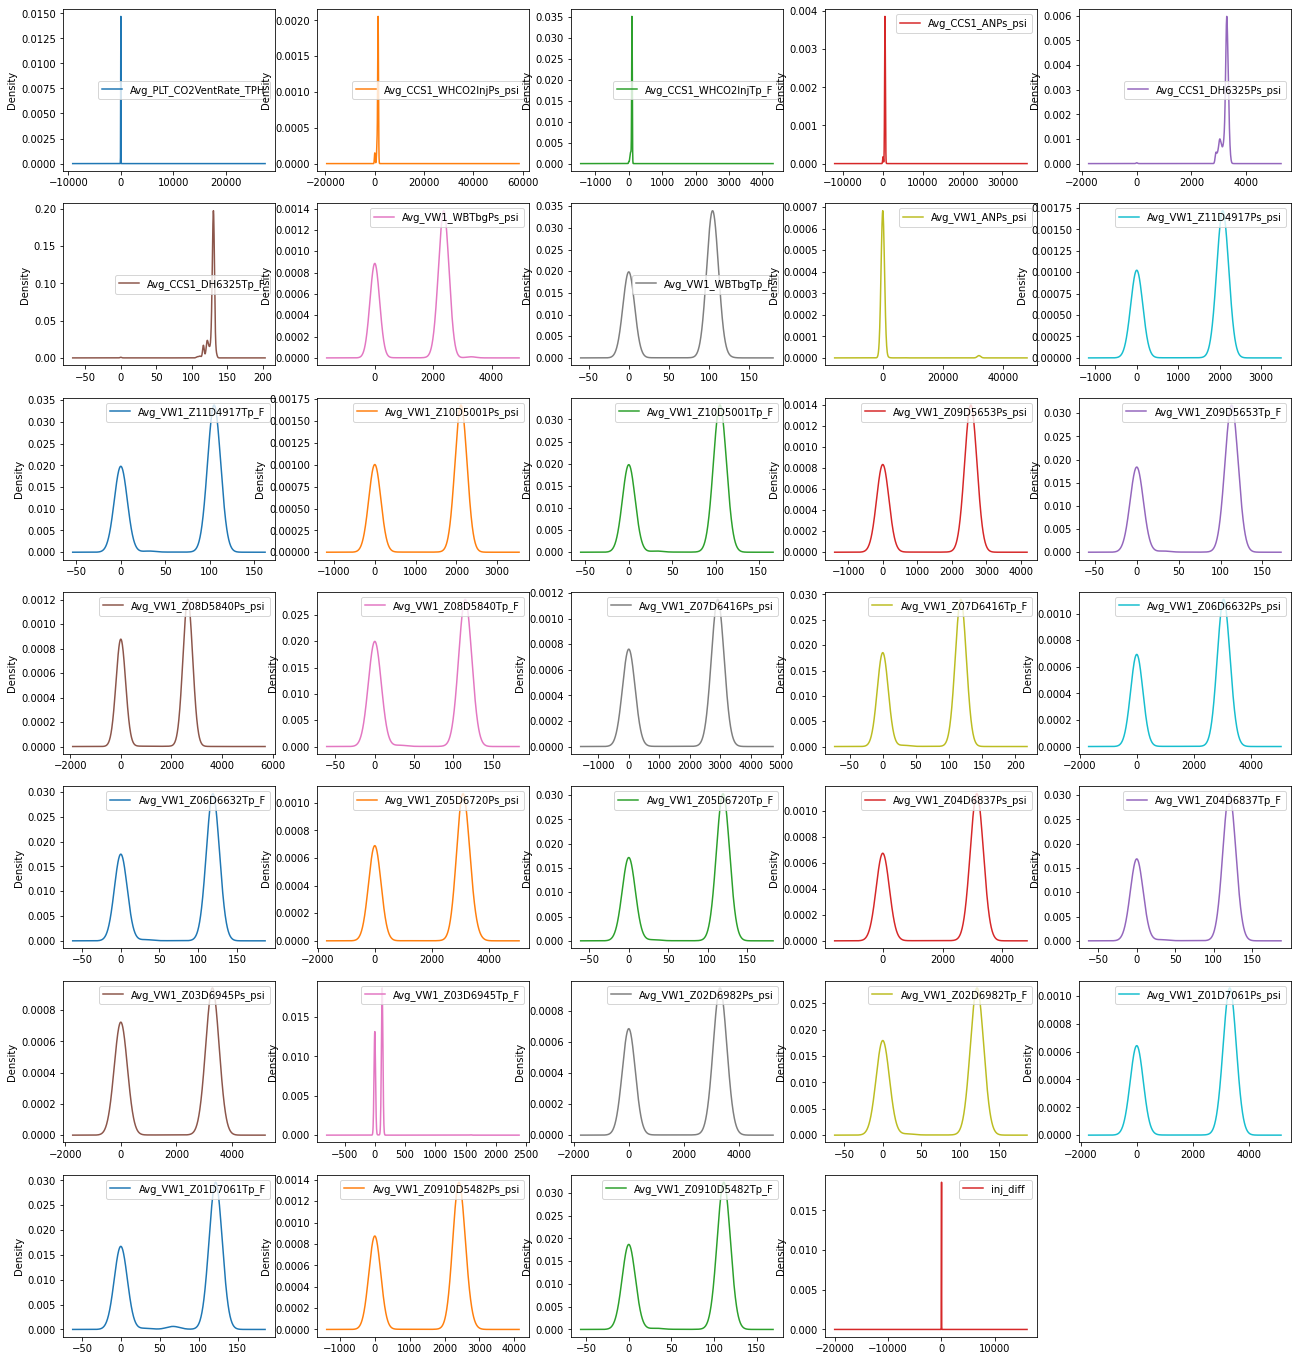

In [14]:
# # Generate density plot of each feature.
data.plot(kind='density', subplots=True, layout=(8,5), sharex=False, figsize = (22,28))
plt.show()

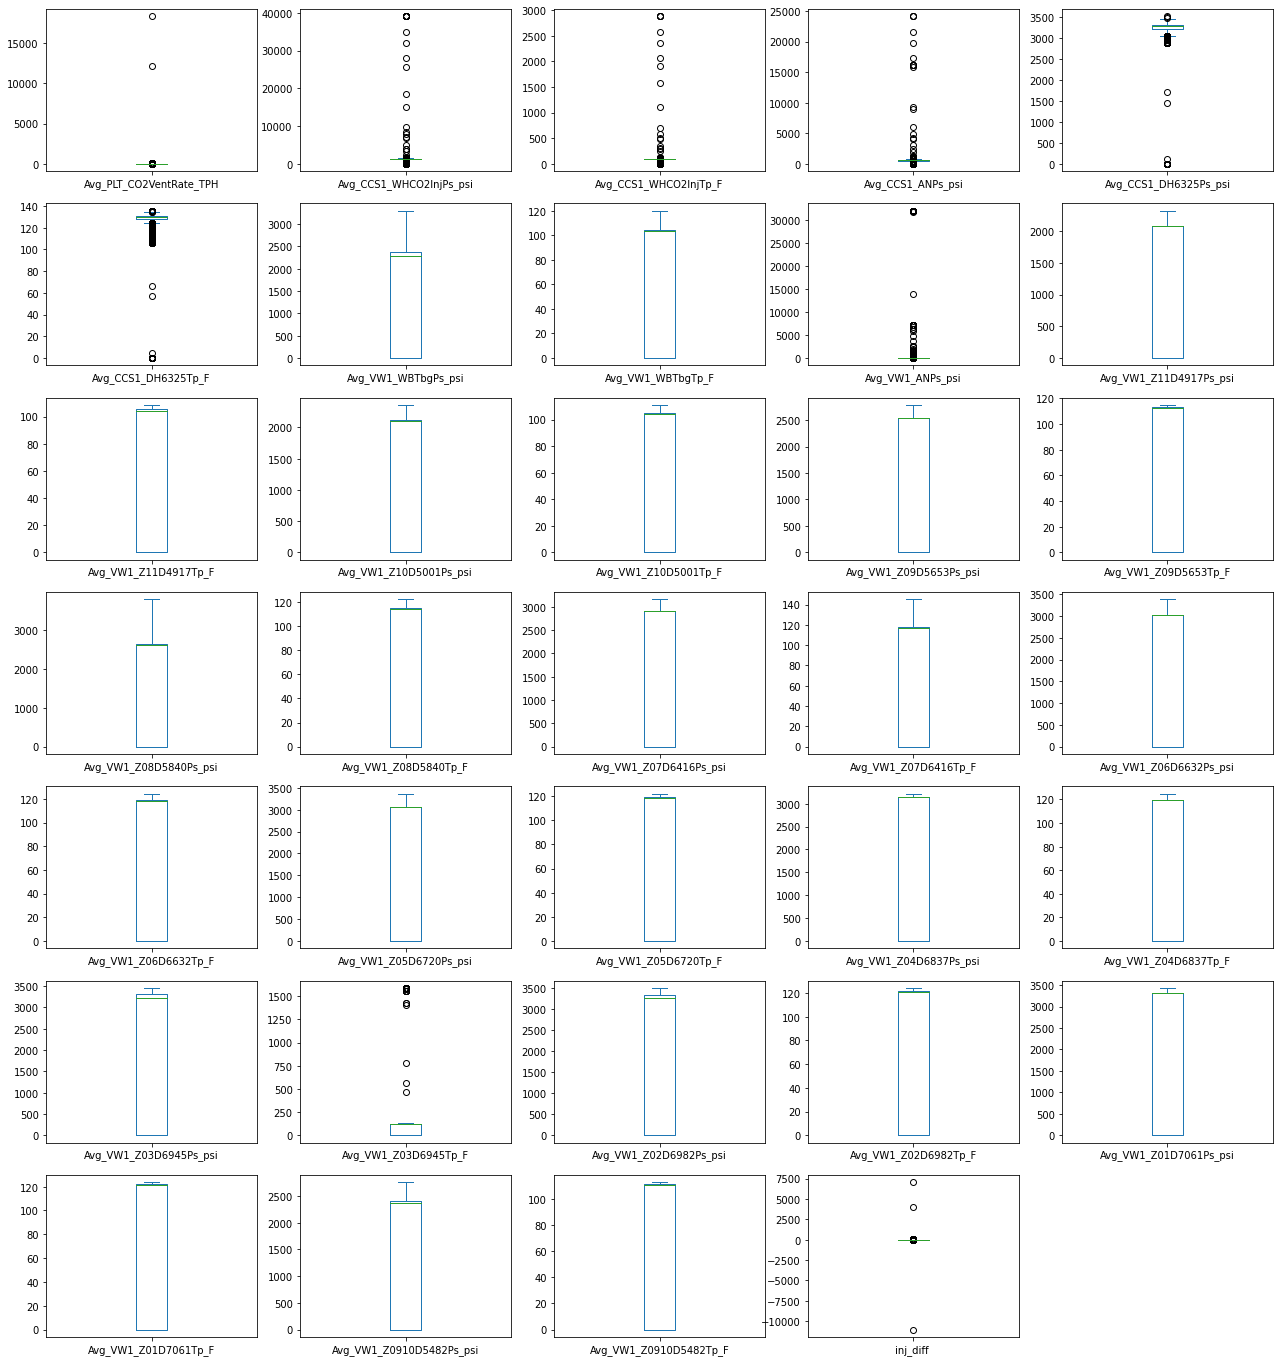

In [15]:
# # Generate box plot of each feature to see thier outlier values
data.plot(kind='box', subplots=True, layout=(8,5), sharey=False, figsize = (22,28))
plt.show()

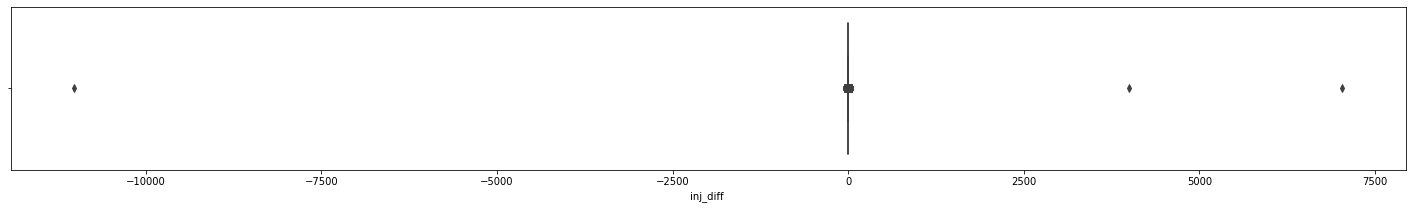

In [16]:
# We analyze the target ('inj_diff\xa0') variable
# inputar o eliminar valores Ooutlaiers
# Target - Boxplot
plt.figure(figsize=(25,3))
sns.boxplot(x='inj_diff\xa0', data=data);

In [17]:
# There are 2 values greater than 50 and 1 less than (-50) according to the graph; therefore,
# remove these 3 values.
data[data['inj_diff\xa0'] > 50].shape, data[data['inj_diff\xa0'] < (-50)].shape

((2, 35), (1, 35))

In [18]:
# Drop values grather than 50
data = data[data['inj_diff\xa0']<=50]

In [19]:
# # Drop values less than (-50)
data = data[data['inj_diff\xa0']>=(-50)]

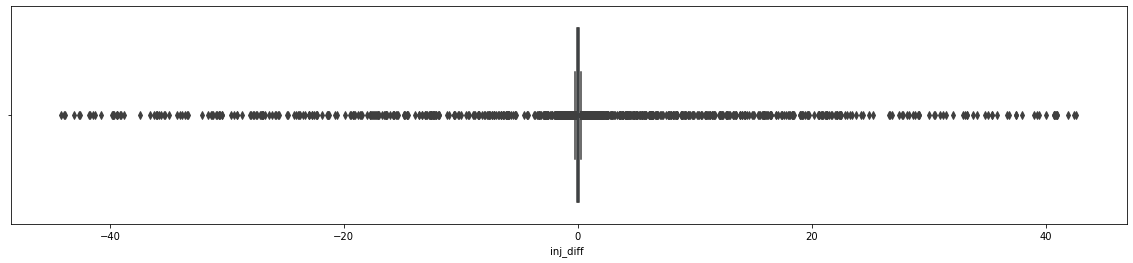

In [20]:
# Box plot of target variable
plt.figure(figsize=(20,4))
sns.boxplot(x='inj_diff\xa0', data=data);

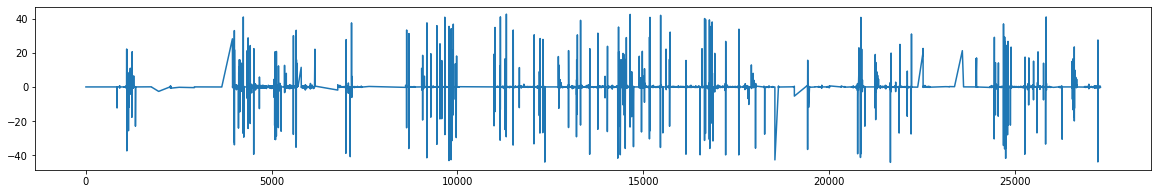

In [21]:
# Graph of the target values
plt.figure(figsize=(20,3))
data["inj_diff\xa0"].plot();

In [22]:
# Removing outlier values, as per the box plot, refers to values that are not considered normal
# of some variables

In [23]:
data = data[data['Avg_PLT_CO2VentRate_TPH'] <= 1000]

In [24]:
data = data[data['Avg_CCS1_WHCO2InjPs_psi'] <= 2000]

In [25]:
data = data[data['Avg_CCS1_WHCO2InjTp_F'] <= 200]

In [26]:
data = data[data['Avg_CCS1_ANPs_psi'] <= 1000]

In [27]:
data = data[data['Avg_VW1_ANPs_psi'] <= 1000]

In [28]:
data = data[data['Avg_VW1_Z03D6945Tp_F'] <= 500]
data = data[data['Avg_VW1_Z03D6945Tp_F'] >= -(200)]

In [29]:
# Created a function to see the outlier values per column.
def porcentaje_outlier(data, columna):
    rango_intercuartil = data[columna].quantile(.75) - data[columna].quantile(.25)
    limite_superior = data[columna].quantile(.75) + 1.5*rango_intercuartil
    limite_inferior = data[columna].quantile(.25) - 1.5*rango_intercuartil
    print('Rango superior: ',limite_superior)
    print('Rango inferior: ',limite_inferior)
    outliers_count = data[(data[columna] > limite_superior) | (data[columna] < limite_inferior)].shape[0]
    print('Porcentaje de outliers en ', columna,': ', np.round(outliers_count*100/data.shape[0],2),'%')
    return limite_superior, limite_inferior, np.round(outliers_count*100/data.shape[0], 2)

In [30]:
list(data.columns)

['SampleTimeUTC',
 'Avg_PLT_CO2VentRate_TPH',
 'Avg_CCS1_WHCO2InjPs_psi',
 'Avg_CCS1_WHCO2InjTp_F',
 'Avg_CCS1_ANPs_psi',
 'Avg_CCS1_DH6325Ps_psi',
 'Avg_CCS1_DH6325Tp_F',
 'Avg_VW1_WBTbgPs_psi',
 'Avg_VW1_WBTbgTp_F',
 'Avg_VW1_ANPs_psi',
 'Avg_VW1_Z11D4917Ps_psi',
 'Avg_VW1_Z11D4917Tp_F',
 'Avg_VW1_Z10D5001Ps_psi',
 'Avg_VW1_Z10D5001Tp_F',
 'Avg_VW1_Z09D5653Ps_psi',
 'Avg_VW1_Z09D5653Tp_F',
 'Avg_VW1_Z08D5840Ps_psi',
 'Avg_VW1_Z08D5840Tp_F',
 'Avg_VW1_Z07D6416Ps_psi',
 'Avg_VW1_Z07D6416Tp_F',
 'Avg_VW1_Z06D6632Ps_psi',
 'Avg_VW1_Z06D6632Tp_F',
 'Avg_VW1_Z05D6720Ps_psi',
 'Avg_VW1_Z05D6720Tp_F',
 'Avg_VW1_Z04D6837Ps_psi',
 'Avg_VW1_Z04D6837Tp_F',
 'Avg_VW1_Z03D6945Ps_psi',
 'Avg_VW1_Z03D6945Tp_F',
 'Avg_VW1_Z02D6982Ps_psi',
 'Avg_VW1_Z02D6982Tp_F',
 'Avg_VW1_Z01D7061Ps_psi',
 'Avg_VW1_Z01D7061Tp_F',
 'Avg_VW1_Z0910D5482Ps_psi',
 'Avg_VW1_Z0910D5482Tp_F',
 'inj_diff\xa0']

In [31]:
# Created a list with the columns to determine the percentage of outlier values
outlier_columns = ['Avg_PLT_CO2VentRate_TPH', 'Avg_CCS1_WHCO2InjPs_psi', 'Avg_CCS1_WHCO2InjTp_F', 'Avg_CCS1_ANPs_psi', 'Avg_CCS1_DH6325Ps_psi', 'Avg_CCS1_DH6325Tp_F',
 'Avg_VW1_WBTbgPs_psi', 'Avg_VW1_WBTbgTp_F', 'Avg_VW1_ANPs_psi', 'Avg_VW1_Z11D4917Ps_psi', 'Avg_VW1_Z11D4917Tp_F', 'Avg_VW1_Z10D5001Ps_psi', 'Avg_VW1_Z10D5001Tp_F',
 'Avg_VW1_Z09D5653Ps_psi', 'Avg_VW1_Z09D5653Tp_F', 'Avg_VW1_Z08D5840Ps_psi', 'Avg_VW1_Z08D5840Tp_F', 'Avg_VW1_Z07D6416Ps_psi', 'Avg_VW1_Z07D6416Tp_F',
 'Avg_VW1_Z06D6632Ps_psi', 'Avg_VW1_Z06D6632Tp_F', 'Avg_VW1_Z05D6720Ps_psi', 'Avg_VW1_Z05D6720Tp_F', 'Avg_VW1_Z04D6837Ps_psi', 'Avg_VW1_Z04D6837Tp_F',
 'Avg_VW1_Z03D6945Ps_psi', 'Avg_VW1_Z03D6945Tp_F', 'Avg_VW1_Z02D6982Ps_psi', 'Avg_VW1_Z02D6982Tp_F', 'Avg_VW1_Z01D7061Ps_psi', 'Avg_VW1_Z01D7061Tp_F',
 'Avg_VW1_Z0910D5482Ps_psi', 'Avg_VW1_Z0910D5482Tp_F']

In [32]:
# Percentage of outlier values of each column
for column in outlier_columns:
    print('___________________', column, porcentaje_outlier(data, column),'___________________')

Rango superior:  0.33333333249999997
Rango inferior:  -0.1999999995
Porcentaje de outliers en  Avg_PLT_CO2VentRate_TPH :  15.32 %
___________________ Avg_PLT_CO2VentRate_TPH (0.33333333249999997, -0.1999999995, 15.32) ___________________
Rango superior:  1458.3825469999997
Rango inferior:  1199.2317870000002
Porcentaje de outliers en  Avg_CCS1_WHCO2InjPs_psi :  19.5 %
___________________ Avg_CCS1_WHCO2InjPs_psi (1458.3825469999997, 1199.2317870000002, 19.5) ___________________
Rango superior:  99.08072559500002
Rango inferior:  93.30045523499999
Porcentaje de outliers en  Avg_CCS1_WHCO2InjTp_F :  22.6 %
___________________ Avg_CCS1_WHCO2InjTp_F (99.08072559500002, 93.30045523499999, 22.6) ___________________
Rango superior:  714.3191404499998
Rango inferior:  404.0875872500001
Porcentaje de outliers en  Avg_CCS1_ANPs_psi :  2.61 %
___________________ Avg_CCS1_ANPs_psi (714.3191404499998, 404.0875872500001, 2.61) ___________________
Rango superior:  3449.4671635
Rango inferior:  3084.40

In [33]:
# Assuming a maximum of 5% of outlier values per column to impute them. The columns with a 
# higher percentage of outlier values are left as they are

outlier_column = ['Avg_CCS1_ANPs_psi', 'Avg_VW1_ANPs_psi', 'Avg_VW1_Z03D6945Tp_F']

for column in outlier_column:
    print('___________________', column, porcentaje_outlier(data, column),'___________________')

Rango superior:  714.3191404499998
Rango inferior:  404.0875872500001
Porcentaje de outliers en  Avg_CCS1_ANPs_psi :  2.61 %
___________________ Avg_CCS1_ANPs_psi (714.3191404499998, 404.0875872500001, 2.61) ___________________
Rango superior:  38.937268222
Rango inferior:  -22.73267453
Porcentaje de outliers en  Avg_VW1_ANPs_psi :  0.71 %
___________________ Avg_VW1_ANPs_psi (38.937268222, -22.73267453, 0.71) ___________________
Rango superior:  304.62362525
Rango inferior:  -182.77417515
Porcentaje de outliers en  Avg_VW1_Z03D6945Tp_F :  0.01 %
___________________ Avg_VW1_Z03D6945Tp_F (304.62362525, -182.77417515, 0.01) ___________________


In [34]:
# Function to replace outlier values with the median; otherwise with the same value
def reemplazar_por_mediana(x, limite_superior, limite_inferior, mediana):
    if (x > limite_superior) | (x < limite_inferior):
        return mediana
    else:
        return x

In [35]:
'''Function that replaces outlier values with the median if the percentage of outliers 
is less than 5%; if it is greater than 5%, the highest values will be replaced by the 98th 
percentile.'''

def tratar_outlier(df, columna):
    limite_superior, limite_inferior, porcentaje = porcentaje_outlier(df, columna)
    if (porcentaje < 5) & (porcentaje > 0):
        mediana = df[columna].median()
        df[columna] = df[columna].apply(lambda x: reemplazar_por_mediana(x, limite_superior, limite_inferior, mediana))
        return df
    elif (porcentaje >= 5):
        percentil_98 = df[columna].quantile(.98)
        df[columna] = df[columna].apply(lambda x: percentil_98 if x > percentil_98 else x)
        return df
    else:
        return df

In [36]:
# Carried out the imputation
for column in outlier_column:
    data = tratar_outlier(data, column)

Rango superior:  714.3191404499998
Rango inferior:  404.0875872500001
Porcentaje de outliers en  Avg_CCS1_ANPs_psi :  2.61 %
Rango superior:  38.937268222
Rango inferior:  -22.73267453
Porcentaje de outliers en  Avg_VW1_ANPs_psi :  0.71 %
Rango superior:  304.62362525
Rango inferior:  -182.77417515
Porcentaje de outliers en  Avg_VW1_Z03D6945Tp_F :  0.01 %


In [37]:
# Verified
for column in outlier_columns:
    print('___________________', column, porcentaje_outlier(data, column),'___________________')

Rango superior:  0.33333333249999997
Rango inferior:  -0.1999999995
Porcentaje de outliers en  Avg_PLT_CO2VentRate_TPH :  15.32 %
___________________ Avg_PLT_CO2VentRate_TPH (0.33333333249999997, -0.1999999995, 15.32) ___________________
Rango superior:  1458.3825469999997
Rango inferior:  1199.2317870000002
Porcentaje de outliers en  Avg_CCS1_WHCO2InjPs_psi :  19.5 %
___________________ Avg_CCS1_WHCO2InjPs_psi (1458.3825469999997, 1199.2317870000002, 19.5) ___________________
Rango superior:  99.08072559500002
Rango inferior:  93.30045523499999
Porcentaje de outliers en  Avg_CCS1_WHCO2InjTp_F :  22.6 %
___________________ Avg_CCS1_WHCO2InjTp_F (99.08072559500002, 93.30045523499999, 22.6) ___________________
Rango superior:  706.99804905
Rango inferior:  415.13086785000013
Porcentaje de outliers en  Avg_CCS1_ANPs_psi :  0.2 %
___________________ Avg_CCS1_ANPs_psi (706.99804905, 415.13086785000013, 0.2) ___________________
Rango superior:  3449.4671635
Rango inferior:  3084.403783500000

In [38]:
# Creation of dummies, converting the date column into more columns
data['SampleTimeUTC'] = pd.to_datetime(data['SampleTimeUTC'])
data['year'] = data['SampleTimeUTC'].dt.year
data['month'] = data['SampleTimeUTC'].dt.month
data['day'] = data['SampleTimeUTC'].dt.day
data['hour'] = data['SampleTimeUTC'].dt.hour

In [39]:
# Drop 'SampleTimeUTC' Column
data.drop(columns=['SampleTimeUTC'], inplace = True)

In [40]:
# The target column is extracted from the DataFrame
columna_target = data.pop('inj_diff\xa0')

# Concatenate the target column at the end of the DataFrame
data = pd.concat([data, columna_target], axis=1)

In [41]:
#data.head(3)

In [42]:
# Scaling of independent variable data

# Select the columns that contain features or independent variables
columnas_independientes = [col for col in data.columns if col != 'inj_diff\xa0']

# Create a StandardScaler() object
scaler = preprocessing.StandardScaler()

# Scaling independent columns
data[columnas_independientes] = scaler.fit_transform(data[columnas_independientes])

In [43]:
data.tail()

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,Avg_VW1_Z11D4917Ps_psi,...,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,year,month,day,hour,inj_diff
27305,-0.236997,0.592900,0.363932,-1.283826,0.722296,0.117226,0.724930,0.774911,-0.447664,0.783204,...,0.845031,0.787036,0.780705,0.950809,0.763349,1.270716,1.522865,-0.148367,-0.086568,-0.122917
27306,-0.208563,0.588845,0.379044,-0.967042,0.702125,0.122266,0.724909,0.775039,-0.452813,0.783196,...,0.844970,0.787043,0.780751,0.950907,0.763186,1.270716,1.522865,-0.148367,0.055614,-0.074305
27307,-0.214250,0.586937,0.333527,-1.050672,0.720682,0.136434,0.724938,0.775021,-0.452462,0.783202,...,0.844917,0.787035,0.780774,0.951009,0.762964,1.270716,1.522865,-0.148367,0.197797,0.093403
27308,-0.200033,0.584688,0.326687,-1.004479,0.719627,0.128916,0.724422,0.775016,3.661742,0.783225,...,0.844546,0.787017,0.780740,0.950716,0.763223,1.270716,1.522865,-0.148367,0.339980,0.062500
27309,-0.194346,0.585387,0.343112,-0.236653,0.717051,0.122573,0.740398,0.774837,-0.384809,0.783222,...,0.844533,0.787857,0.780739,0.962377,0.763093,1.270716,1.522865,-0.148367,0.482163,-0.068749


<Figure size 1584x1296 with 0 Axes>

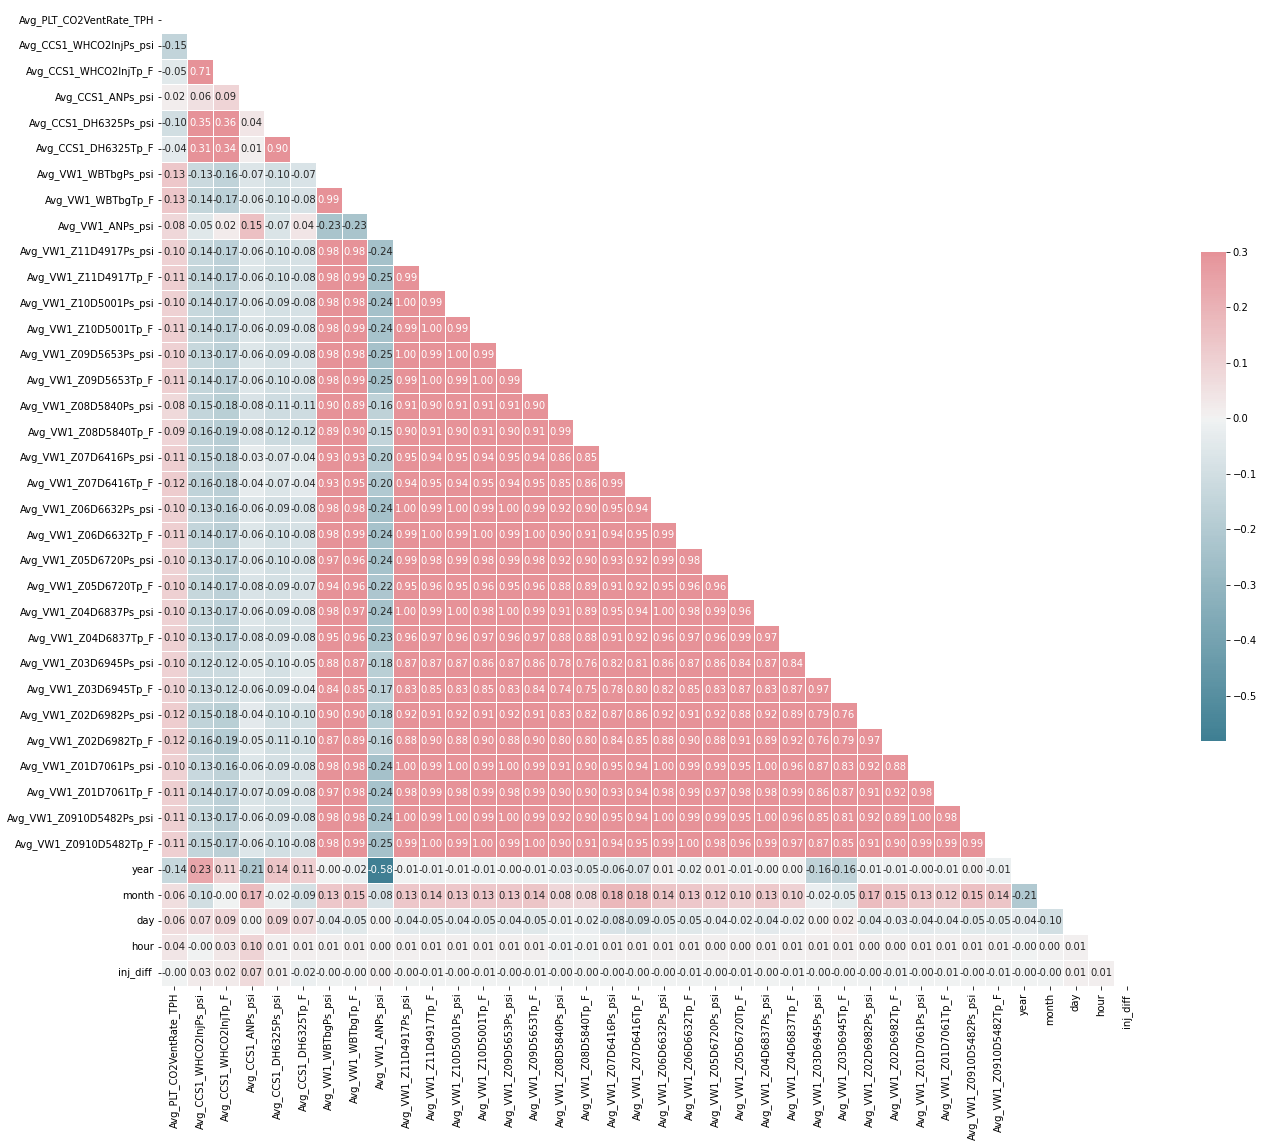

In [44]:
# Compute correlation matrix
plt.figure(figsize=(22,18))
corr_matrix = data.corr()

# Generate heatmap of correlation matrix

# generate a mask for upper triangle
mask = np.zeros_like(corr_matrix, dtype = bool)
mask[np.triu_indices_from(mask)] = True

# set up matplotlib figure
f, ax = plt.subplots(figsize = (22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask = mask, cmap = cmap, vmax = 0.3, center = 0,
           square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.5}, annot = True, fmt = '.2f');


In [45]:
#!pip install boruta

VARIABLE SELECTION

In [46]:
# Define the timer function that gives us a deadline
def timer(start_time = None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [47]:
x = data.drop(['inj_diff\xa0'], axis=1).values

In [48]:
y = data['inj_diff\xa0'].values

In [49]:
# Selection of variables that best fit the model using the Boruta library
rfR = RandomForestRegressor(n_estimators = 50, n_jobs = 4, max_depth = 5)
boruta_selector = BorutaPy(rfR, n_estimators = 20, verbose=2)
start_time = timer(None)
boruta_selector.fit(x, y)
timer(start_time)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	7
Rejected: 	25
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	7
Rejected: 	25
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	7
Rejected: 	25
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	7
Rejected: 	25
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	6
Rejected: 	26
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	6
Rejected: 	26
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	6
Rejected: 	26
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	6
Rejected: 	26
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	6
Rejected: 	26
I

In [50]:
# Initial features
print ('\n Initial features: ', data.drop(['inj_diff\xa0'], axis=1).columns.tolist() )

# Number of selected features
print ('\n Number of selected features:')
print (boruta_selector.n_features_)


 Initial features:  ['Avg_PLT_CO2VentRate_TPH', 'Avg_CCS1_WHCO2InjPs_psi', 'Avg_CCS1_WHCO2InjTp_F', 'Avg_CCS1_ANPs_psi', 'Avg_CCS1_DH6325Ps_psi', 'Avg_CCS1_DH6325Tp_F', 'Avg_VW1_WBTbgPs_psi', 'Avg_VW1_WBTbgTp_F', 'Avg_VW1_ANPs_psi', 'Avg_VW1_Z11D4917Ps_psi', 'Avg_VW1_Z11D4917Tp_F', 'Avg_VW1_Z10D5001Ps_psi', 'Avg_VW1_Z10D5001Tp_F', 'Avg_VW1_Z09D5653Ps_psi', 'Avg_VW1_Z09D5653Tp_F', 'Avg_VW1_Z08D5840Ps_psi', 'Avg_VW1_Z08D5840Tp_F', 'Avg_VW1_Z07D6416Ps_psi', 'Avg_VW1_Z07D6416Tp_F', 'Avg_VW1_Z06D6632Ps_psi', 'Avg_VW1_Z06D6632Tp_F', 'Avg_VW1_Z05D6720Ps_psi', 'Avg_VW1_Z05D6720Tp_F', 'Avg_VW1_Z04D6837Ps_psi', 'Avg_VW1_Z04D6837Tp_F', 'Avg_VW1_Z03D6945Ps_psi', 'Avg_VW1_Z03D6945Tp_F', 'Avg_VW1_Z02D6982Ps_psi', 'Avg_VW1_Z02D6982Tp_F', 'Avg_VW1_Z01D7061Ps_psi', 'Avg_VW1_Z01D7061Tp_F', 'Avg_VW1_Z0910D5482Ps_psi', 'Avg_VW1_Z0910D5482Tp_F', 'year', 'month', 'day', 'hour']

 Number of selected features:
8


In [51]:
# Perform a ranking of the variables (X) that contribute to the prediction

feature_df = pd.DataFrame(data.drop(['inj_diff\xa0'], axis=1).columns.tolist(), columns=['features'])
feature_df['rank'] = boruta_selector.ranking_
feature_df = feature_df.sort_values('rank', ascending = True).reset_index(drop=True)
print('\n Top %d features:' % boruta_selector.n_features_)
print(feature_df.head(boruta_selector.n_features_))


 Top 8 features:
                   features  rank
0   Avg_PLT_CO2VentRate_TPH     1
1   Avg_CCS1_WHCO2InjPs_psi     1
2     Avg_CCS1_WHCO2InjTp_F     1
3         Avg_CCS1_ANPs_psi     1
4     Avg_CCS1_DH6325Ps_psi     1
5       Avg_CCS1_DH6325Tp_F     1
6  Avg_VW1_Z0910D5482Ps_psi     1
7      Avg_VW1_Z02D6982Tp_F     1


In [52]:
# Check ranking of features
print(data.drop(['inj_diff\xa0'], axis = 1).columns.tolist())
print ('\n Feature ranking:')
print (boruta_selector.ranking_)

['Avg_PLT_CO2VentRate_TPH', 'Avg_CCS1_WHCO2InjPs_psi', 'Avg_CCS1_WHCO2InjTp_F', 'Avg_CCS1_ANPs_psi', 'Avg_CCS1_DH6325Ps_psi', 'Avg_CCS1_DH6325Tp_F', 'Avg_VW1_WBTbgPs_psi', 'Avg_VW1_WBTbgTp_F', 'Avg_VW1_ANPs_psi', 'Avg_VW1_Z11D4917Ps_psi', 'Avg_VW1_Z11D4917Tp_F', 'Avg_VW1_Z10D5001Ps_psi', 'Avg_VW1_Z10D5001Tp_F', 'Avg_VW1_Z09D5653Ps_psi', 'Avg_VW1_Z09D5653Tp_F', 'Avg_VW1_Z08D5840Ps_psi', 'Avg_VW1_Z08D5840Tp_F', 'Avg_VW1_Z07D6416Ps_psi', 'Avg_VW1_Z07D6416Tp_F', 'Avg_VW1_Z06D6632Ps_psi', 'Avg_VW1_Z06D6632Tp_F', 'Avg_VW1_Z05D6720Ps_psi', 'Avg_VW1_Z05D6720Tp_F', 'Avg_VW1_Z04D6837Ps_psi', 'Avg_VW1_Z04D6837Tp_F', 'Avg_VW1_Z03D6945Ps_psi', 'Avg_VW1_Z03D6945Tp_F', 'Avg_VW1_Z02D6982Ps_psi', 'Avg_VW1_Z02D6982Tp_F', 'Avg_VW1_Z01D7061Ps_psi', 'Avg_VW1_Z01D7061Tp_F', 'Avg_VW1_Z0910D5482Ps_psi', 'Avg_VW1_Z0910D5482Tp_F', 'year', 'month', 'day', 'hour']

 Feature ranking:
[ 1  1  1  1  1  1 21  5  6 26 19 15 17 23 13 28 26 24 29 21 18 25 10  8
  7 10 12 19  1  3 15  1 14 30  4  2  9]


In [53]:
# Keep the variables of interest (eliminating columns with fixed values
selected = data.drop(['inj_diff\xa0'],axis=1).columns[boruta_selector.support_]
data = data[selected]
data['inj_diff\xa0'] = y

In [54]:
data.head()

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z0910D5482Ps_psi,inj_diff
243,-0.256901,-4.226511,-4.864265,-0.031564,-1.744972,-1.531578,0.815526,0.809524,0.0
244,-0.256901,-4.226511,-4.864265,-0.031564,-1.745016,-1.531877,0.815526,0.809524,0.0
245,-0.256901,-4.226511,-4.864265,-0.031564,-1.745046,-1.531674,0.815526,0.809524,0.0
246,-0.256901,-4.226511,-4.864265,-0.031564,-1.745016,-1.531658,0.815526,0.809524,0.0
247,-0.256901,-4.226511,-4.864265,-0.031564,-1.744966,-1.531513,0.815526,0.809524,0.0


split the dataframe into train and test

In [55]:
X = data.drop(columns=['inj_diff\xa0'])
y = data['inj_diff\xa0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

LINEAR REGRESSION (LinearRegression())

In [56]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

pred_train_LinearReg = regressor.predict(X_train)
pred_test_LinearReg = regressor.predict(X_test)

r2_LR = r2_score(y_test, pred_test_LinearReg)

print('RMSE train',round(sqrt(mean_squared_error(y_train, pred_train_LinearReg)),4))
print('RMSE test',round(sqrt(mean_squared_error(y_test, pred_test_LinearReg)),4))
print('R^2 LinearRegressor: ', round(r2_LR, 4))

RMSE train 3.7061
RMSE test 4.171
R^2 LinearRegressor:  0.0093


DECISSION TREE REGRESSOR (DecisionTreeRegressor)

In [57]:
regressor1 = DecisionTreeRegressor(random_state=42)
regressor1.fit(X_train, y_train)

pred_train_DecTreeReg = regressor1.predict(X_train)
pred_test_DecTreeReg = regressor1.predict(X_test)

r2_DecTreeReg = r2_score(y_test, pred_test_DecTreeReg)

print('RMSE train',round(sqrt(mean_squared_error(y_train, pred_train_DecTreeReg)),4))
print('RMSE test',round(sqrt(mean_squared_error(y_test, pred_test_DecTreeReg)),4))
print('R^2 DecisionTreeRegressor: ', round(r2_DecTreeReg,4))

RMSE train 0.0
RMSE test 4.7747
R^2 DecisionTreeRegressor:  -0.2982


RANDOM FOREST REGRESSOR (RandomForestRegressor)

In [58]:
regressor2 = RandomForestRegressor(n_estimators=200, random_state=42)
regressor2.fit(X_train, y_train)

pred_train_RandForReg = regressor2.predict(X_train)
pred_test_RandForReg = regressor2.predict(X_test)

r2_RandForReg = r2_score(y_test, pred_test_RandForReg)

print('RMSE train',round(sqrt(mean_squared_error(y_train, pred_train_RandForReg)),4))
print('RMSE test',round(sqrt(mean_squared_error(y_test, pred_test_RandForReg)),4))
print('R^2 RandomForestRegressor: ', round(r2_RandForReg,4))

RMSE train 1.1694
RMSE test 3.586
R^2 RandomForestRegressor:  0.2677


SVM (SVR)

In [59]:
svm_model = SVR(kernel='rbf', C=100, gamma='auto')
svm_model.fit(X_train, y_train)

pred_train_SVR = svm_model.predict(X_train)
pred_test_SVR = svm_model.predict(X_test)

r2_SVR = r2_score(y_test, pred_test_SVR)

print('RMSE train',round(sqrt(mean_squared_error(y_train, pred_train_SVR)),4))
print('RMSE test',round(sqrt(mean_squared_error(y_test, pred_test_SVR)),4))
print('R^2 SVR: ', round(r2_SVR,4))

RMSE train 3.5272
RMSE test 4.1216
R^2 SVR:  0.0327


 GRADIENT BOOSTING REGRESSOR (GradientBoostingRegressor)

In [60]:
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.5, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

pred_train_GradBoostReg = gb_model.predict(X_train)
pred_test_GradBoostReg = gb_model.predict(X_test)

r2_GradBoostReg = r2_score(y_test, pred_test_GradBoostReg)

print('RMSE train',round(sqrt(mean_squared_error(y_train, pred_train_GradBoostReg)),4))
print('RMSE test',round(sqrt(mean_squared_error(y_test, pred_test_GradBoostReg)),4))
print('R^2 GradientBoostingRegressor: ', round(r2_GradBoostReg,4))

RMSE train 0.2663
RMSE test 3.7558
R^2 GradientBoostingRegressor:  0.1968


RIDGE (Ridge)

In [61]:
ridgeReg = Ridge(alpha = 0.01, normalize = True) 

# train model
ridgeReg.fit(X_train, y_train)

# prediction
pred_train_Ridge = ridgeReg.predict(X_train)
pred_test_Ridge = ridgeReg.predict(X_test)

r2_Ridge = r2_score(y_test, pred_test_Ridge)

print('RMSE train',round(sqrt(mean_squared_error(y_train, pred_train_Ridge)),4))
print('RMSE test',round(sqrt(mean_squared_error(y_test, pred_test_Ridge)),4))
print('R^2 Ridge: ', round(r2_Ridge,4))

RMSE train 3.7062
RMSE test 4.1713
R^2 Ridge:  0.0092


C:\Users\lenovo\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 



# DATA TEST

In [62]:
# data_test
data_test = pd.read_csv('illinois_basing_test_04112023.csv')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SampleTimeUTC             201 non-null    object 
 1   Avg_PLT_CO2VentRate_TPH   201 non-null    float64
 2   Avg_CCS1_WHCO2InjPs_psi   201 non-null    float64
 3   Avg_CCS1_WHCO2InjTp_F     201 non-null    float64
 4   Avg_CCS1_ANPs_psi         201 non-null    float64
 5   Avg_CCS1_DH6325Ps_psi     201 non-null    float64
 6   Avg_CCS1_DH6325Tp_F       201 non-null    float64
 7   Avg_VW1_WBTbgPs_psi       201 non-null    float64
 8   Avg_VW1_WBTbgTp_F         201 non-null    float64
 9   Avg_VW1_ANPs_psi          197 non-null    float64
 10  Avg_VW1_Z11D4917Ps_psi    201 non-null    float64
 11  Avg_VW1_Z11D4917Tp_F      201 non-null    float64
 12  Avg_VW1_Z10D5001Ps_psi    201 non-null    float64
 13  Avg_VW1_Z10D5001Tp_F      201 non-null    float64
 14  Avg_VW1_Z0

In [63]:
# See missing values
missing_values_table(data_test)

Your selected dataframe has 34 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Avg_VW1_Z03D6945Ps_psi,133,66.17
Avg_VW1_Z03D6945Tp_F,133,66.17
Avg_VW1_ANPs_psi,4,1.99


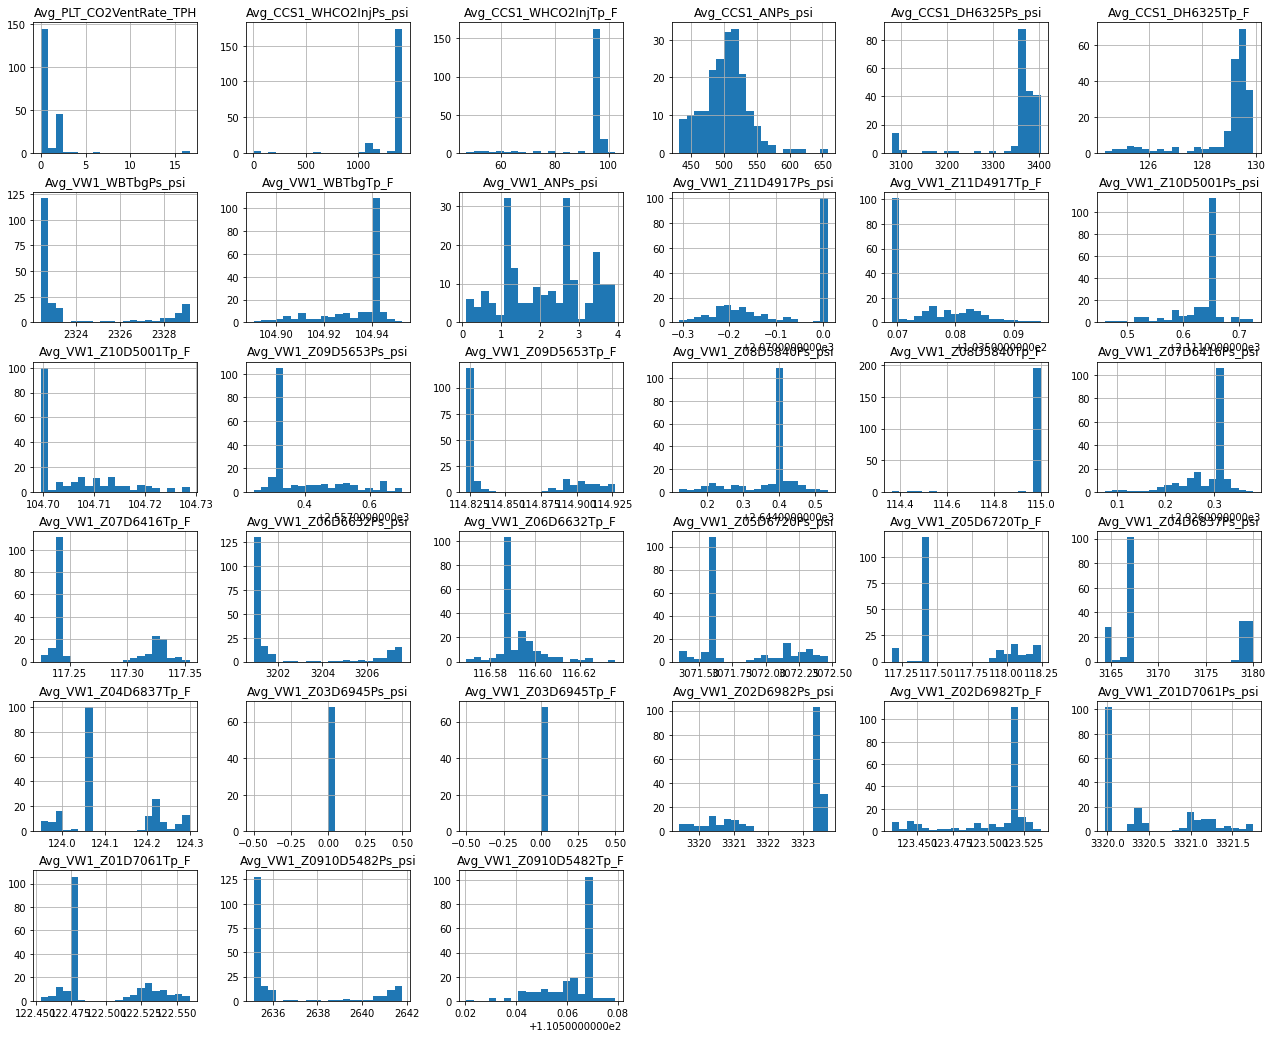

In [64]:
# Generate histograms of each feature
data_test.hist(bins=20, figsize=(22, 18))
plt.show()

In [65]:
#  Impute variables with NaN values using the median of the rest of the data.

Avg_VW1_ANPs_psi_medianTest = data_test[data_test['Avg_VW1_ANPs_psi'] <= 4]['Avg_VW1_ANPs_psi'].median() 

data_test['Avg_VW1_ANPs_psi'].fillna(Avg_VW1_ANPs_psi_medianTest, inplace = True)

In [66]:
Avg_VW1_Z03D6945Tp_F_medianTest = data_test[data_test['Avg_VW1_Z03D6945Tp_F'] <= 4]['Avg_VW1_Z03D6945Tp_F'].median() 

data_test['Avg_VW1_Z03D6945Tp_F'].fillna(Avg_VW1_Z03D6945Tp_F_medianTest, inplace = True)

In [67]:
Avg_VW1_Z03D6945Ps_psi_medianTest = data_test[data_test['Avg_VW1_Z03D6945Ps_psi'] <= 4]['Avg_VW1_Z03D6945Ps_psi'].median() 

data_test['Avg_VW1_Z03D6945Ps_psi'].fillna(Avg_VW1_Z03D6945Ps_psi_medianTest, inplace = True)

In [68]:
# Outlier columns of data test = make the same as the train data
outlier_columnsTest = ['Avg_PLT_CO2VentRate_TPH', 'Avg_CCS1_WHCO2InjPs_psi', 'Avg_CCS1_WHCO2InjTp_F', 'Avg_CCS1_ANPs_psi', 'Avg_CCS1_DH6325Ps_psi', 'Avg_CCS1_DH6325Tp_F',
 'Avg_VW1_WBTbgPs_psi', 'Avg_VW1_WBTbgTp_F', 'Avg_VW1_ANPs_psi', 'Avg_VW1_Z11D4917Ps_psi', 'Avg_VW1_Z11D4917Tp_F', 'Avg_VW1_Z10D5001Ps_psi', 'Avg_VW1_Z10D5001Tp_F',
 'Avg_VW1_Z09D5653Ps_psi', 'Avg_VW1_Z09D5653Tp_F', 'Avg_VW1_Z08D5840Ps_psi', 'Avg_VW1_Z08D5840Tp_F', 'Avg_VW1_Z07D6416Ps_psi', 'Avg_VW1_Z07D6416Tp_F',
 'Avg_VW1_Z06D6632Ps_psi', 'Avg_VW1_Z06D6632Tp_F', 'Avg_VW1_Z05D6720Ps_psi', 'Avg_VW1_Z05D6720Tp_F', 'Avg_VW1_Z04D6837Ps_psi', 'Avg_VW1_Z04D6837Tp_F',
 'Avg_VW1_Z03D6945Ps_psi', 'Avg_VW1_Z03D6945Tp_F', 'Avg_VW1_Z02D6982Ps_psi', 'Avg_VW1_Z02D6982Tp_F', 'Avg_VW1_Z01D7061Ps_psi', 'Avg_VW1_Z01D7061Tp_F',
 'Avg_VW1_Z0910D5482Ps_psi', 'Avg_VW1_Z0910D5482Tp_F']

In [69]:
for column in outlier_columnsTest:
    print('___________________', column, porcentaje_outlier(data_test, column),'___________________')

Rango superior:  3.6708333325
Rango inferior:  -1.7624999995000001
Porcentaje de outliers en  Avg_PLT_CO2VentRate_TPH :  1.99 %
___________________ Avg_PLT_CO2VentRate_TPH (3.6708333325, -1.7624999995000001, 1.99) ___________________
Rango superior:  1430.1163414999999
Rango inferior:  1380.7723775000002
Porcentaje de outliers en  Avg_CCS1_WHCO2InjPs_psi :  14.93 %
___________________ Avg_CCS1_WHCO2InjPs_psi (1430.1163414999999, 1380.7723775000002, 14.93) ___________________
Rango superior:  97.842933915
Rango inferior:  94.42691827499999
Porcentaje de outliers en  Avg_CCS1_WHCO2InjTp_F :  10.45 %
___________________ Avg_CCS1_WHCO2InjTp_F (97.842933915, 94.42691827499999, 10.45) ___________________
Rango superior:  579.6418589500001
Rango inferior:  425.9661033499999
Porcentaje de outliers en  Avg_CCS1_ANPs_psi :  1.99 %
___________________ Avg_CCS1_ANPs_psi (579.6418589500001, 425.9661033499999, 1.99) ___________________
Rango superior:  3412.5569255
Rango inferior:  3335.476521499999

In [70]:
# Impute until 5% outliers
outlier_columnTest = ['Avg_CCS1_ANPs_psi', 'Avg_VW1_Z10D5001Tp_F', 'Avg_VW1_Z09D5653Ps_psi', 
                      'Avg_VW1_Z08D5840Tp_F', 'Avg_VW1_Z07D6416Ps_psi', 'Avg_VW1_Z0910D5482Tp_F']

# less than 5% outliers
for column in outlier_columnTest:
    print('___________________', column, porcentaje_outlier(data_test, column),'___________________')

Rango superior:  579.6418589500001
Rango inferior:  425.9661033499999
Porcentaje de outliers en  Avg_CCS1_ANPs_psi :  1.99 %
___________________ Avg_CCS1_ANPs_psi (579.6418589500001, 425.9661033499999, 1.99) ___________________
Rango superior:  104.7272505
Rango inferior:  104.68285130000001
Porcentaje de outliers en  Avg_VW1_Z10D5001Tp_F :  1.99 %
___________________ Avg_VW1_Z10D5001Tp_F (104.7272505, 104.68285130000001, 1.99) ___________________
Rango superior:  2557.6411075000005
Rango inferior:  2557.1336954999997
Porcentaje de outliers en  Avg_VW1_Z09D5653Ps_psi :  3.48 %
___________________ Avg_VW1_Z09D5653Ps_psi (2557.6411075000005, 2557.1336954999997, 3.48) ___________________
Rango superior:  115.0
Rango inferior:  115.0
Porcentaje de outliers en  Avg_VW1_Z08D5840Tp_F :  3.98 %
___________________ Avg_VW1_Z08D5840Tp_F (115.0, 115.0, 3.98) ___________________
Rango superior:  2926.3885075
Rango inferior:  2926.1845195000005
Porcentaje de outliers en  Avg_VW1_Z07D6416Ps_psi :  4

In [71]:
for column in outlier_columnTest:
    data_test = tratar_outlier(data_test, column)

Rango superior:  579.6418589500001
Rango inferior:  425.9661033499999
Porcentaje de outliers en  Avg_CCS1_ANPs_psi :  1.99 %
Rango superior:  104.7272505
Rango inferior:  104.68285130000001
Porcentaje de outliers en  Avg_VW1_Z10D5001Tp_F :  1.99 %
Rango superior:  2557.6411075000005
Rango inferior:  2557.1336954999997
Porcentaje de outliers en  Avg_VW1_Z09D5653Ps_psi :  3.48 %
Rango superior:  115.0
Rango inferior:  115.0
Porcentaje de outliers en  Avg_VW1_Z08D5840Tp_F :  3.98 %
Rango superior:  2926.3885075
Rango inferior:  2926.1845195000005
Porcentaje de outliers en  Avg_VW1_Z07D6416Ps_psi :  4.98 %
Rango superior:  110.58671415
Rango inferior:  110.54027054999997
Porcentaje de outliers en  Avg_VW1_Z0910D5482Tp_F :  2.49 %


In [72]:
for column in outlier_columnsTest:
    print('___________________', column, porcentaje_outlier(data_test, column),'___________________')

Rango superior:  3.6708333325
Rango inferior:  -1.7624999995000001
Porcentaje de outliers en  Avg_PLT_CO2VentRate_TPH :  1.99 %
___________________ Avg_PLT_CO2VentRate_TPH (3.6708333325, -1.7624999995000001, 1.99) ___________________
Rango superior:  1430.1163414999999
Rango inferior:  1380.7723775000002
Porcentaje de outliers en  Avg_CCS1_WHCO2InjPs_psi :  14.93 %
___________________ Avg_CCS1_WHCO2InjPs_psi (1430.1163414999999, 1380.7723775000002, 14.93) ___________________
Rango superior:  97.842933915
Rango inferior:  94.42691827499999
Porcentaje de outliers en  Avg_CCS1_WHCO2InjTp_F :  10.45 %
___________________ Avg_CCS1_WHCO2InjTp_F (97.842933915, 94.42691827499999, 10.45) ___________________
Rango superior:  575.32421245
Rango inferior:  428.55669125000003
Porcentaje de outliers en  Avg_CCS1_ANPs_psi :  0.0 %
___________________ Avg_CCS1_ANPs_psi (575.32421245, 428.55669125000003, 0.0) ___________________
Rango superior:  3412.5569255
Rango inferior:  3335.4765214999998
Porcenta

In [73]:

data_test['SampleTimeUTC'] = pd.to_datetime(data_test['SampleTimeUTC'])
data_test['year'] = data_test['SampleTimeUTC'].dt.year
data_test['month'] = data_test['SampleTimeUTC'].dt.month
data_test['day'] = data_test['SampleTimeUTC'].dt.day
data_test['hour'] = data_test['SampleTimeUTC'].dt.hour
#data_test

In [74]:
# Drop 'SampleTimeUTC' column
data_test.drop(columns=['SampleTimeUTC'], inplace = True)
data_test.head(3)

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,Avg_VW1_Z11D4917Ps_psi,...,Avg_VW1_Z02D6982Ps_psi,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,year,month,day,hour
0,0.825000,1406.469561,95.529213,522.013451,3383.554036,129.535322,2329.030835,104.912923,0.100585,2069.938165,...,3323.462998,123.443262,3320.276693,122.462348,2641.618345,110.552962,2012,11,18,8
1,0.641667,1406.399989,95.191933,510.494516,3385.778632,129.518488,2329.015361,104.909203,0.100585,2069.942957,...,3323.513243,123.453597,3320.269031,122.457593,2641.630886,110.550592,2012,11,18,9
2,0.633333,1406.588710,95.546059,510.899432,3383.531185,129.466555,2329.055794,104.911063,2.290528,2069.882166,...,3323.566427,123.445062,3320.298985,122.453574,2641.633761,110.543437,2012,11,18,10


In [75]:
# Scaling data
scalerDataTest = preprocessing.StandardScaler()

# scalling independent columns
data_test[data_test.columns] = scalerDataTest.fit_transform(data_test[data_test.columns])


In [76]:
data_test = data_test[selected]
data_test

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z0910D5482Ps_psi
0,-0.055050,0.287639,0.214201,0.720699,0.410308,0.477192,-2.249300,2.127392
1,-0.159234,0.287312,0.178770,0.329863,0.437166,0.462950,-1.874667,2.132670
2,-0.163969,0.288198,0.215971,0.343602,0.410032,0.419013,-2.184052,2.133880
3,-0.163969,0.290131,0.198775,0.377430,0.422499,0.431849,-2.277030,2.146779
4,-0.263418,0.288640,0.226243,0.346413,0.428526,0.412842,-2.060626,2.156891
...,...,...,...,...,...,...,...,...
196,0.446926,0.345671,0.317688,-2.046274,0.591578,0.181113,0.387809,1.649108
197,0.446926,0.344251,0.284411,-2.331674,0.599627,0.193680,0.230128,1.730774
198,0.451662,0.346346,0.312033,0.439984,0.617334,0.214144,0.419346,1.766554
199,0.366421,0.347394,0.308340,0.173841,0.646660,0.243615,0.292657,1.767127


In [77]:
# Predictions with data test
y_pred_ridge_Test = ridgeReg.predict(data_test)

In [78]:
y_pred_ridge_Test

array([ 6.69276845e-02, -6.70262866e-03, -2.72108895e-03,  2.55917952e-03,
        8.79980103e-03,  2.23857360e-02, -5.13520531e-02, -4.23648375e-02,
       -4.93007598e-02, -4.53129731e-02, -2.64894756e-02, -7.19307660e-03,
        1.54573672e-01,  1.95561964e-01, -4.46478794e-02, -2.11592745e-01,
       -3.47854461e-01, -2.01648935e-01, -6.18045757e-02, -9.16661338e-02,
       -2.51294242e-01, -2.29946795e-01, -2.09188708e-01, -3.48652721e-01,
       -3.79940094e-01, -3.98842739e-01, -3.62690894e-01, -2.30072779e-01,
       -1.82864459e-01, -1.11961889e-01, -7.54341998e-02, -1.93741275e-01,
       -2.33789474e-01, -2.52008908e-01, -1.96053902e-01, -2.33700258e-01,
       -9.63803657e-02,  4.43179156e-01,  3.09787042e-01,  1.54720067e-01,
        3.09398187e-01,  3.44603716e-01,  2.07356324e-01,  1.22419976e-01,
        1.92597592e-01,  1.90775931e-01,  2.06435055e-01, -1.09638608e+00,
       -1.05142852e+00, -8.48512525e-01, -4.71235126e-01, -7.45160295e-01,
       -1.37124182e-01, -

In [79]:
df_submission = pd.read_csv("C:/Users/lenovo/Desktop/illinois_basing_answer_sample_submission.csv")
df_submission.head()

,inj_diff
0,0.581298
1,0.542078
2,0.571329
3,0.584218
4,0.615249


In [80]:
df_submission.columns

Index(['inj_diff'], dtype='object')

In [81]:
df_submission["inj_diff\xa0"] = y_pred_ridge_Test
df_submission

,inj_diff,inj_diff
0,0.581298,0.066928
1,0.542078,-0.006703
2,0.571329,-0.002721
3,0.584218,0.002559
4,0.615249,0.008800
...,...,...
196,0.792107,-0.286692
197,0.700920,-0.368772
198,1.525612,0.345560
199,1.445210,0.268567


In [82]:
df_submission = df_submission.drop(["inj_diff"], axis = 1)

In [83]:
df_submission

,inj_diff
0,0.066928
1,-0.006703
2,-0.002721
3,0.002559
4,0.008800
...,...
196,-0.286692
197,-0.368772
198,0.345560
199,0.268567


In [84]:
# Save the file with predictions
#df_submission.to_csv("C:/Users/lenovo/Desktop/illinois_basing_answer_sample_submission.csv",
                     index = False)

IndentationError: unexpected indent (Temp/ipykernel_16608/3749371450.py, line 3)